# AlexNet

In [1]:
GPU = True

SHUFFLE = True
BATCH_SIZE = 32
NUM_WORKERS = 16

LR = 1e-2
MOMENTUM = 0.9
EPOCH = 500

### Inpurts
To plot in Jupyter Notebook, it is necessery to set:
    
    %matplotlib inline

In [2]:
import torch
from torch import nn, device
from torchvision import datasets
from torchvision.transforms import Compose, Resize, RandomResizedCrop, RandomHorizontalFlip, ToTensor
from torch.utils.data import DataLoader
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

### Config Device

To use GPU, assume that we are o a CUDA machine,
that this should print a CUDA device;
else should print 'cpu'.
    
    :param gpu: bool, Weather to use GPU.
    :return devices: Devices that the Net will take place.

In [3]:
def device_(gpu):
    devices = device(
        'cuda:0' if (torch.cuda.is_available() and gpu)
        else 'cpu')

    print(
        '\n', 3 * '*',
        ' This calculation takes place in {}'.format(devices),
              3 * '*', '\n')

    return devices

### Setting and Loading Data set
transform:
1. Resize the image to 256*256
2. Crop the given PIL Image to random size and aspect ratio.
3. Horizontally flip the given PIL Image randomly 
   with a given probability.
4. Convert a PIL Image to tensor.

"data" function:

    :param shuffle: set to True to have the data reshuffled at every epoch.
    :param batch_size: how many samples per batch to load.
    :param num_workers: 
        how many subprocesses to use for data loading. 
        0 means that the data will be loaded in the main process.
    :return train_set: train data set.
    :return test_set: test data set.
    :return train_loader: train data lo ader.
    :return test_loader: test data loader.
    :return len(train_set): the length of train data set.
    :return len(test_set): the length test data set.

In [4]:
def data(shuffle, batch_size, num_workers):
    transform = Compose([
        Resize(256),
        RandomResizedCrop(227),
        RandomHorizontalFlip(),
        ToTensor(),
    ])

    train_set = datasets.ImageFolder(
        root='./monkey/training',
        transform=transform,
    )

    test_set = datasets.ImageFolder(
        root='./monkey/validation',
        transform=transform,
    )

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
    )
    
    sets = (train_set, test_set)
    loaders = (train_loader, test_loader)
    lengths = (len(train_set), len(test_set))

    print(
        'About this data set:\n',
        'There are {} data in training set.\n'.format(lengths[0]),
        'There are {} data in testing set.\n'.format(lengths[1]))

    return sets, loaders, lengths

### Print an image just for fun XD~~

In [5]:
def show_monkey(which_one, set_):
    print('Monkey No. {} in Training set ~~\n'.format(which_one))
    im = Image.open(set_.imgs[which_one][0])
    plt.imshow(im)
    plt.show()

### AlexNet

In [6]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()

        self.c1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(
                in_channels=3,
                out_channels=96,
                kernel_size=11,
                stride=4,
            )),
            ('ReLU', nn.ReLU(inplace=True)),
            ('s1', nn.MaxPool2d(
                kernel_size=3,
                stride=2,
            )),
        ]))

        self.c2 = nn.Sequential(OrderedDict([
            ('c2', nn.Conv2d(
                in_channels=96,
                out_channels=256,
                kernel_size=5,
                padding=2,
            )),
            ('ReLU', nn.ReLU(inplace=True)),
            ('s2', nn.MaxPool2d(
                kernel_size=3,
                stride=2,
            )),
        ]))

        self.c3 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(
                in_channels=256,
                out_channels=384,
                padding=1,
                kernel_size=3,
            )),
            ('ReLU', nn.ReLU(inplace=True)),
        ]))

        self.c4 = nn.Sequential(OrderedDict([
            ('c4', nn.Conv2d(
                in_channels=384,
                out_channels=384,
                kernel_size=3,
                padding=1,
            )),
            ('ReLU', nn.ReLU(inplace=True))
        ]))

        self.c5 = nn.Sequential(OrderedDict([
            ('c5', nn.Conv2d(
                in_channels=384,
                out_channels=256,
                kernel_size=3,
                padding=1,
            )),
            ('ReLU', nn.ReLU(inplace=True)),
            ('s5', nn.MaxPool2d(
                kernel_size=3,
                stride=2,
            )),
        ]))

        self.fc1 = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(
                in_features=6 * 6 * 256,
                out_features=4096,
            )),
            ('ReLU', nn.ReLU(inplace=True)),
            ('drop', nn.Dropout(0.5)),
        ]))

        self.fc2 = nn.Sequential(OrderedDict([
            ('l2', nn.Linear(
                in_features=4096,
                out_features=4096,
            )),
            ('ReLU', nn.ReLU(inplace=True)),
            ('drop', nn.Dropout(0.5)),
        ]))

        self.fc3 = nn.Sequential(OrderedDict([
            ('l3', nn.Linear(
                in_features=4096,
                out_features=10,
            )),
        ]))

    def forward(self, x):
        x = self.c5(self.c4(self.c3(self.c2(self.c1(x)))))
        x = x.view(-1, 6 * 6 * 256)
        x = self.fc3(self.fc2(self.fc1(x)))
        
        return x

### Training Fuction

In [7]:
def training_func(
        batch_size,
        loaders, lengths,
        net, devices,
        optimizer, loss_func):

    print('Start Training ~~~ >_<')
    % matplotlib notebook
    plt.ion()
    fig = plt.figure(1, figsize=(5, 6))
    
    train_loss_x, train_loss_y = [], []
    test_loss_x, test_loss_y = [], []
    train_accuracy_x, train_accuracy_y = [], []
    test_accuracy_x, test_accuracy_y = [], []

    iter_ = 0
    for epoch in range(EPOCH):
        for i, data_ in enumerate(loaders[0]):
            """ load data """
            images, labels = data_
            images, labels = images.to(devices), labels.to(devices)

            """ initialize optimizer """
            optimizer.zero_grad()

            """ get output from net """
            output = net(images)

            """ calculate loss """
            loss = loss_func(output, labels)
            loss.backward()
            loss = loss.item()

            """ optimizer """
            optimizer.step()

            """ in-data """
            if iter_ % 10 == 0:
                train_loss_x.append(epoch+i*batch_size/lengths[0])
                train_loss_y.append(loss)
                
                print('Epoch: {}. Trained data: {}. Loss: {}.'.format(
                    epoch, i * batch_size, loss))
            iter_ += 1

        """ out data """
        if epoch % 1 == 0 or epoch == EPOCH:

            test_loss = 0.0
            counter = 0.0

            total = 0
            correct = 0

            for i, data_ in enumerate(loaders[1]):
                """ load data """
                images, labels = data_
                images, labels = images.to(devices), labels.to(devices)

                """ get output from net """
                output = net(images)

                """ accumulate loss """
                test_loss += loss_func(output, labels).item()

                """ get predictions """
                prediction_prob, prediction = torch.max(output, 1)
                labels = labels.cpu().numpy()
                prediction = prediction.cpu().numpy()
                
                """ calculate total accuracy """
                total += len(labels)
                for j, t_l in enumerate(labels):
                    if t_l == prediction[j]:
                        correct += 1
                counter += 1
                
            """ append data into arrays """
            test_loss_x.append(epoch)
            test_loss_y.append(test_loss/counter)
            test_accuracy_x.append(epoch)
            test_accuracy_y.append(100 * correct / total)
            
            print('Out-Data Test:\n',
                  'Epoch: {}. Test data: {}.\n Loss: {}. Accuracy: {}\n'.format(
                      epoch, lengths[1],
                      test_loss / counter,
                      100 * correct / total))
            
            """ data visualization """
            fig.clear()
            ax = plt.subplot(211)
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.plot(train_loss_x, train_loss_y, 'r-')
            ax.plot(test_loss_x, test_loss_y, 'b-')
            
            ax1 = plt.subplot(212)
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Accuracy')
            ax1.plot(test_accuracy_x, test_accuracy_y, 'b-')
            fig.canvas.draw()
            # plt.show()

    print('Finished Training ~~~ ^_^\n')
    plt.ioff()
    %matplotlib inline

### Main Function
1. Set device.
2. Assign data sets and data loaders.
3. Print an image just for fun XD.
4. Set the Net.
5. set loss function and optimizer.
6. Train the model.
7. Save the param.

In [8]:
def main():
    """ 1. """
    devices = device_(GPU)

    """ 2. """
    sets, loaders, lengths = data(
        SHUFFLE, BATCH_SIZE, NUM_WORKERS)

    """ 3. """
    show_monkey(100, sets[0])

    """ 4. """
    net = AlexNet().to(devices)

    """ 5. """
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        net.parameters(),
        lr=LR, momentum=MOMENTUM)

    """ 6. """
    training_func(
        BATCH_SIZE,
        loaders, lengths,
        net, devices,
        optimizer, loss_func)

    """ 7. """
    torch.save(net.state_dict(), 'APP/alex_net.pkl')


 ***  This calculation takes place in cuda:0 *** 

About this data set:
 There are 1097 data in training set.
 There are 272 data in testing set.

Monkey No. 100 in Training set ~~



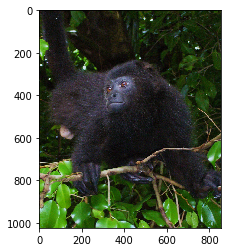

Start Training ~~~ >_<


<IPython.core.display.Javascript object>


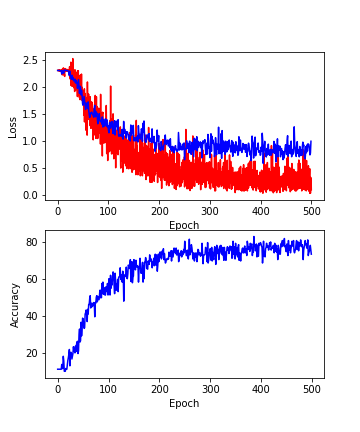

Epoch: 0. Trained data: 0. Loss: 2.3028621673583984.
Epoch: 0. Trained data: 320. Loss: 2.303309679031372.
Epoch: 0. Trained data: 640. Loss: 2.301276683807373.
Epoch: 0. Trained data: 960. Loss: 2.3051817417144775.
Out-Data Test:
 Epoch: 0. Test data: 272.
 Loss: 2.301365746392144. Accuracy: 11.029411764705882

Epoch: 1. Trained data: 160. Loss: 2.30397367477417.
Epoch: 1. Trained data: 480. Loss: 2.299506187438965.
Epoch: 1. Trained data: 800. Loss: 2.2995924949645996.
Out-Data Test:
 Epoch: 1. Test data: 272.
 Loss: 2.301432980431451. Accuracy: 11.029411764705882

Epoch: 2. Trained data: 0. Loss: 2.2992470264434814.
Epoch: 2. Trained data: 320. Loss: 2.295959234237671.
Epoch: 2. Trained data: 640. Loss: 2.3111507892608643.
Epoch: 2. Trained data: 960. Loss: 2.304292678833008.
Out-Data Test:
 Epoch: 2. Test data: 272.
 Loss: 2.301657650205824. Accuracy: 11.029411764705882

Epoch: 3. Trained data: 160. Loss: 2.2980780601501465.
Epoch: 3. Trained data: 480. Loss: 2.301422119140625.
Epo

Epoch: 28. Trained data: 320. Loss: 2.3030543327331543.
Epoch: 28. Trained data: 640. Loss: 2.015138626098633.
Epoch: 28. Trained data: 960. Loss: 2.225907564163208.
Out-Data Test:
 Epoch: 28. Test data: 272.
 Loss: 2.2145601643456354. Accuracy: 16.544117647058822

Epoch: 29. Trained data: 160. Loss: 2.1404430866241455.
Epoch: 29. Trained data: 480. Loss: 2.181525468826294.
Epoch: 29. Trained data: 800. Loss: 2.521535634994507.
Out-Data Test:
 Epoch: 29. Test data: 272.
 Loss: 2.1443916426764593. Accuracy: 18.014705882352942

Epoch: 30. Trained data: 0. Loss: 2.074252128601074.
Epoch: 30. Trained data: 320. Loss: 2.053562641143799.
Epoch: 30. Trained data: 640. Loss: 2.131417751312256.
Epoch: 30. Trained data: 960. Loss: 2.0735185146331787.
Out-Data Test:
 Epoch: 30. Test data: 272.
 Loss: 2.1732936170366077. Accuracy: 19.485294117647058

Epoch: 31. Trained data: 160. Loss: 2.028008460998535.
Epoch: 31. Trained data: 480. Loss: 1.9954428672790527.
Epoch: 31. Trained data: 800. Loss: 2.

Epoch: 56. Trained data: 320. Loss: 1.5986634492874146.
Epoch: 56. Trained data: 640. Loss: 1.6112297773361206.
Epoch: 56. Trained data: 960. Loss: 1.5853800773620605.
Out-Data Test:
 Epoch: 56. Test data: 272.
 Loss: 1.7002826664182875. Accuracy: 43.01470588235294

Epoch: 57. Trained data: 160. Loss: 1.6482242345809937.
Epoch: 57. Trained data: 480. Loss: 1.5339431762695312.
Epoch: 57. Trained data: 800. Loss: 1.4564824104309082.
Out-Data Test:
 Epoch: 57. Test data: 272.
 Loss: 1.6768361065122817. Accuracy: 40.44117647058823

Epoch: 58. Trained data: 0. Loss: 1.1060426235198975.
Epoch: 58. Trained data: 320. Loss: 1.220411777496338.
Epoch: 58. Trained data: 640. Loss: 2.08892560005188.
Epoch: 58. Trained data: 960. Loss: 1.7280657291412354.
Out-Data Test:
 Epoch: 58. Test data: 272.
 Loss: 1.6855348613527086. Accuracy: 36.76470588235294

Epoch: 59. Trained data: 160. Loss: 1.4044564962387085.
Epoch: 59. Trained data: 480. Loss: 1.785132884979248.
Epoch: 59. Trained data: 800. Loss: 1

Epoch: 84. Trained data: 640. Loss: 1.8601794242858887.
Epoch: 84. Trained data: 960. Loss: 1.2982126474380493.
Out-Data Test:
 Epoch: 84. Test data: 272.
 Loss: 1.359984662797716. Accuracy: 49.63235294117647

Epoch: 85. Trained data: 160. Loss: 1.4066293239593506.
Epoch: 85. Trained data: 480. Loss: 1.006951928138733.
Epoch: 85. Trained data: 800. Loss: 1.3375730514526367.
Out-Data Test:
 Epoch: 85. Test data: 272.
 Loss: 1.3544266025225322. Accuracy: 53.6764705882353

Epoch: 86. Trained data: 0. Loss: 1.1971325874328613.
Epoch: 86. Trained data: 320. Loss: 1.2212775945663452.
Epoch: 86. Trained data: 640. Loss: 1.0825045108795166.
Epoch: 86. Trained data: 960. Loss: 1.4236516952514648.
Out-Data Test:
 Epoch: 86. Test data: 272.
 Loss: 1.3828681243790522. Accuracy: 49.63235294117647

Epoch: 87. Trained data: 160. Loss: 0.9830129742622375.
Epoch: 87. Trained data: 480. Loss: 1.4655932188034058.
Epoch: 87. Trained data: 800. Loss: 1.1096817255020142.
Out-Data Test:
 Epoch: 87. Test data

Epoch: 112. Trained data: 640. Loss: 0.9270678758621216.
Epoch: 112. Trained data: 960. Loss: 0.8241701126098633.
Out-Data Test:
 Epoch: 112. Test data: 272.
 Loss: 1.372763666841719. Accuracy: 51.838235294117645

Epoch: 113. Trained data: 160. Loss: 1.1089035272598267.
Epoch: 113. Trained data: 480. Loss: 0.8040487766265869.
Epoch: 113. Trained data: 800. Loss: 1.1307770013809204.
Out-Data Test:
 Epoch: 113. Test data: 272.
 Loss: 1.1091326673825581. Accuracy: 62.86764705882353

Epoch: 114. Trained data: 0. Loss: 0.9439270496368408.
Epoch: 114. Trained data: 320. Loss: 0.5023859739303589.
Epoch: 114. Trained data: 640. Loss: 1.1826077699661255.
Epoch: 114. Trained data: 960. Loss: 1.1080288887023926.
Out-Data Test:
 Epoch: 114. Test data: 272.
 Loss: 1.3030531141493056. Accuracy: 58.088235294117645

Epoch: 115. Trained data: 160. Loss: 1.0455375909805298.
Epoch: 115. Trained data: 480. Loss: 0.9041627049446106.
Epoch: 115. Trained data: 800. Loss: 1.0454530715942383.
Out-Data Test:
 E

Epoch: 140. Trained data: 0. Loss: 0.4830639958381653.
Epoch: 140. Trained data: 320. Loss: 0.7272366285324097.
Epoch: 140. Trained data: 640. Loss: 1.0335943698883057.
Epoch: 140. Trained data: 960. Loss: 0.7169734239578247.
Out-Data Test:
 Epoch: 140. Test data: 272.
 Loss: 1.0299662351608276. Accuracy: 66.54411764705883

Epoch: 141. Trained data: 160. Loss: 0.8733230233192444.
Epoch: 141. Trained data: 480. Loss: 0.9038182497024536.
Epoch: 141. Trained data: 800. Loss: 0.780841588973999.
Out-Data Test:
 Epoch: 141. Test data: 272.
 Loss: 1.1046028865708246. Accuracy: 65.44117647058823

Epoch: 142. Trained data: 0. Loss: 0.9269861578941345.
Epoch: 142. Trained data: 320. Loss: 1.15426766872406.
Epoch: 142. Trained data: 640. Loss: 0.630988597869873.
Epoch: 142. Trained data: 960. Loss: 0.5727285146713257.
Out-Data Test:
 Epoch: 142. Test data: 272.
 Loss: 1.0417493846681383. Accuracy: 68.01470588235294

Epoch: 143. Trained data: 160. Loss: 0.8640176653862.
Epoch: 143. Trained data: 4

Out-Data Test:
 Epoch: 167. Test data: 272.
 Loss: 0.9902755485640632. Accuracy: 68.75

Epoch: 168. Trained data: 0. Loss: 0.8789920210838318.
Epoch: 168. Trained data: 320. Loss: 0.6062253713607788.
Epoch: 168. Trained data: 640. Loss: 0.7916151285171509.
Epoch: 168. Trained data: 960. Loss: 0.8037988543510437.
Out-Data Test:
 Epoch: 168. Test data: 272.
 Loss: 1.325383398267958. Accuracy: 58.088235294117645

Epoch: 169. Trained data: 160. Loss: 0.6874917149543762.
Epoch: 169. Trained data: 480. Loss: 0.6255111694335938.
Epoch: 169. Trained data: 800. Loss: 0.4449574649333954.
Out-Data Test:
 Epoch: 169. Test data: 272.
 Loss: 1.1707118021117315. Accuracy: 66.91176470588235

Epoch: 170. Trained data: 0. Loss: 0.7212702035903931.
Epoch: 170. Trained data: 320. Loss: 0.6149048209190369.
Epoch: 170. Trained data: 640. Loss: 0.566484808921814.
Epoch: 170. Trained data: 960. Loss: 0.9638672471046448.
Out-Data Test:
 Epoch: 170. Test data: 272.
 Loss: 1.367409759097629. Accuracy: 59.9264705

Epoch: 195. Trained data: 800. Loss: 0.7120794057846069.
Out-Data Test:
 Epoch: 195. Test data: 272.
 Loss: 0.9283113479614258. Accuracy: 69.8529411764706

Epoch: 196. Trained data: 0. Loss: 0.6736917495727539.
Epoch: 196. Trained data: 320. Loss: 0.6358374357223511.
Epoch: 196. Trained data: 640. Loss: 0.48313021659851074.
Epoch: 196. Trained data: 960. Loss: 0.2299058735370636.
Out-Data Test:
 Epoch: 196. Test data: 272.
 Loss: 1.199377437432607. Accuracy: 63.970588235294116

Epoch: 197. Trained data: 160. Loss: 0.7367608547210693.
Epoch: 197. Trained data: 480. Loss: 0.6207306385040283.
Epoch: 197. Trained data: 800. Loss: 0.7158103585243225.
Out-Data Test:
 Epoch: 197. Test data: 272.
 Loss: 1.0353329579035442. Accuracy: 67.27941176470588

Epoch: 198. Trained data: 0. Loss: 0.3803197741508484.
Epoch: 198. Trained data: 320. Loss: 0.44039860367774963.
Epoch: 198. Trained data: 640. Loss: 0.7781644463539124.
Epoch: 198. Trained data: 960. Loss: 0.5188817977905273.
Out-Data Test:
 Epo

Epoch: 223. Trained data: 160. Loss: 0.3753614127635956.
Epoch: 223. Trained data: 480. Loss: 0.68255215883255.
Epoch: 223. Trained data: 800. Loss: 0.7499520778656006.
Out-Data Test:
 Epoch: 223. Test data: 272.
 Loss: 0.8298055628935496. Accuracy: 75.0

Epoch: 224. Trained data: 0. Loss: 0.4468942880630493.
Epoch: 224. Trained data: 320. Loss: 0.3786928653717041.
Epoch: 224. Trained data: 640. Loss: 0.3491774797439575.
Epoch: 224. Trained data: 960. Loss: 0.31922590732574463.
Out-Data Test:
 Epoch: 224. Test data: 272.
 Loss: 0.8829365273316702. Accuracy: 69.48529411764706

Epoch: 225. Trained data: 160. Loss: 0.2512059509754181.
Epoch: 225. Trained data: 480. Loss: 0.5074946880340576.
Epoch: 225. Trained data: 800. Loss: 0.43460094928741455.
Out-Data Test:
 Epoch: 225. Test data: 272.
 Loss: 0.808186305893792. Accuracy: 75.0

Epoch: 226. Trained data: 0. Loss: 0.19166073203086853.
Epoch: 226. Trained data: 320. Loss: 0.5086065530776978.
Epoch: 226. Trained data: 640. Loss: 0.8716228

Out-Data Test:
 Epoch: 250. Test data: 272.
 Loss: 0.6503182086679671. Accuracy: 80.1470588235294

Epoch: 251. Trained data: 160. Loss: 0.36227527260780334.
Epoch: 251. Trained data: 480. Loss: 0.2910141944885254.
Epoch: 251. Trained data: 800. Loss: 0.18877480924129486.
Out-Data Test:
 Epoch: 251. Test data: 272.
 Loss: 0.8586252596643236. Accuracy: 74.63235294117646

Epoch: 252. Trained data: 0. Loss: 0.24001459777355194.
Epoch: 252. Trained data: 320. Loss: 0.5548872947692871.
Epoch: 252. Trained data: 640. Loss: 1.2106930017471313.
Epoch: 252. Trained data: 960. Loss: 0.5680163502693176.
Out-Data Test:
 Epoch: 252. Test data: 272.
 Loss: 0.8519897593392266. Accuracy: 75.0

Epoch: 253. Trained data: 160. Loss: 0.4279859960079193.
Epoch: 253. Trained data: 480. Loss: 0.9096843004226685.
Epoch: 253. Trained data: 800. Loss: 0.5216967463493347.
Out-Data Test:
 Epoch: 253. Test data: 272.
 Loss: 0.8437623845206367. Accuracy: 72.42647058823529

Epoch: 254. Trained data: 0. Loss: 0.371663

Epoch: 278. Trained data: 640. Loss: 0.46874260902404785.
Epoch: 278. Trained data: 960. Loss: 0.49015673995018005.
Out-Data Test:
 Epoch: 278. Test data: 272.
 Loss: 0.8837064769532945. Accuracy: 72.79411764705883

Epoch: 279. Trained data: 160. Loss: 0.4249228239059448.
Epoch: 279. Trained data: 480. Loss: 0.44127053022384644.
Epoch: 279. Trained data: 800. Loss: 0.4159044623374939.
Out-Data Test:
 Epoch: 279. Test data: 272.
 Loss: 0.9273530112372504. Accuracy: 73.16176470588235

Epoch: 280. Trained data: 0. Loss: 0.3503674566745758.
Epoch: 280. Trained data: 320. Loss: 0.42612773180007935.
Epoch: 280. Trained data: 640. Loss: 0.7876009941101074.
Epoch: 280. Trained data: 960. Loss: 0.419881671667099.
Out-Data Test:
 Epoch: 280. Test data: 272.
 Loss: 0.9529742267396715. Accuracy: 73.8970588235294

Epoch: 281. Trained data: 160. Loss: 0.32668179273605347.
Epoch: 281. Trained data: 480. Loss: 0.468079537153244.
Epoch: 281. Trained data: 800. Loss: 0.09654323011636734.
Out-Data Test:


Epoch: 306. Trained data: 0. Loss: 0.4605962038040161.
Epoch: 306. Trained data: 320. Loss: 0.4279395341873169.
Epoch: 306. Trained data: 640. Loss: 0.13966932892799377.
Epoch: 306. Trained data: 960. Loss: 0.25628721714019775.
Out-Data Test:
 Epoch: 306. Test data: 272.
 Loss: 1.0161462426185608. Accuracy: 71.32352941176471

Epoch: 307. Trained data: 160. Loss: 0.31699424982070923.
Epoch: 307. Trained data: 480. Loss: 0.4076940417289734.
Epoch: 307. Trained data: 800. Loss: 0.24129237234592438.
Out-Data Test:
 Epoch: 307. Test data: 272.
 Loss: 0.9611547854211595. Accuracy: 70.22058823529412

Epoch: 308. Trained data: 0. Loss: 0.22926968336105347.
Epoch: 308. Trained data: 320. Loss: 0.43302956223487854.
Epoch: 308. Trained data: 640. Loss: 0.3816640079021454.
Epoch: 308. Trained data: 960. Loss: 0.30660325288772583.
Out-Data Test:
 Epoch: 308. Test data: 272.
 Loss: 0.9124839040968153. Accuracy: 75.36764705882354

Epoch: 309. Trained data: 160. Loss: 0.7262041568756104.
Epoch: 309. T

Epoch: 333. Trained data: 800. Loss: 0.07439309358596802.
Out-Data Test:
 Epoch: 333. Test data: 272.
 Loss: 0.7953100601832072. Accuracy: 76.1029411764706

Epoch: 334. Trained data: 0. Loss: 0.6408266425132751.
Epoch: 334. Trained data: 320. Loss: 0.33860892057418823.
Epoch: 334. Trained data: 640. Loss: 0.2902974784374237.
Epoch: 334. Trained data: 960. Loss: 0.30278828740119934.
Out-Data Test:
 Epoch: 334. Test data: 272.
 Loss: 0.8211314744419522. Accuracy: 77.20588235294117

Epoch: 335. Trained data: 160. Loss: 0.34259912371635437.
Epoch: 335. Trained data: 480. Loss: 0.13812631368637085.
Epoch: 335. Trained data: 800. Loss: 0.2126309871673584.
Out-Data Test:
 Epoch: 335. Test data: 272.
 Loss: 0.9861906237072415. Accuracy: 75.36764705882354

Epoch: 336. Trained data: 0. Loss: 0.27379700541496277.
Epoch: 336. Trained data: 320. Loss: 0.15479078888893127.
Epoch: 336. Trained data: 640. Loss: 0.44797641038894653.
Epoch: 336. Trained data: 960. Loss: 0.2421615719795227.
Out-Data Test

Epoch: 361. Trained data: 160. Loss: 0.3560481369495392.
Epoch: 361. Trained data: 480. Loss: 0.22369037568569183.
Epoch: 361. Trained data: 800. Loss: 0.13789522647857666.
Out-Data Test:
 Epoch: 361. Test data: 272.
 Loss: 0.856694350639979. Accuracy: 73.16176470588235

Epoch: 362. Trained data: 0. Loss: 0.3396128714084625.
Epoch: 362. Trained data: 320. Loss: 0.2508953809738159.
Epoch: 362. Trained data: 640. Loss: 0.3112759590148926.
Epoch: 362. Trained data: 960. Loss: 0.07164005935192108.
Out-Data Test:
 Epoch: 362. Test data: 272.
 Loss: 0.857381284236908. Accuracy: 74.26470588235294

Epoch: 363. Trained data: 160. Loss: 0.3026677072048187.
Epoch: 363. Trained data: 480. Loss: 0.3106827735900879.
Epoch: 363. Trained data: 800. Loss: 0.2140437364578247.
Out-Data Test:
 Epoch: 363. Test data: 272.
 Loss: 0.7863171928458743. Accuracy: 76.1029411764706

Epoch: 364. Trained data: 0. Loss: 0.1618127077817917.
Epoch: 364. Trained data: 320. Loss: 0.14544492959976196.
Epoch: 364. Trained

Epoch: 388. Trained data: 960. Loss: 0.13685911893844604.
Out-Data Test:
 Epoch: 388. Test data: 272.
 Loss: 1.0073147084977891. Accuracy: 78.30882352941177

Epoch: 389. Trained data: 160. Loss: 0.26138848066329956.
Epoch: 389. Trained data: 480. Loss: 0.22845503687858582.
Epoch: 389. Trained data: 800. Loss: 0.33342990279197693.
Out-Data Test:
 Epoch: 389. Test data: 272.
 Loss: 1.0694461994700961. Accuracy: 75.0

Epoch: 390. Trained data: 0. Loss: 0.24898962676525116.
Epoch: 390. Trained data: 320. Loss: 0.22432364523410797.
Epoch: 390. Trained data: 640. Loss: 0.128086119890213.
Epoch: 390. Trained data: 960. Loss: 0.3746228516101837.
Out-Data Test:
 Epoch: 390. Test data: 272.
 Loss: 0.7244441906611124. Accuracy: 76.1029411764706

Epoch: 391. Trained data: 160. Loss: 0.07779200375080109.
Epoch: 391. Trained data: 480. Loss: 0.09961406886577606.
Epoch: 391. Trained data: 800. Loss: 0.12717896699905396.
Out-Data Test:
 Epoch: 391. Test data: 272.
 Loss: 0.7824410465028551. Accuracy: 

Epoch: 416. Trained data: 0. Loss: 0.12648546695709229.
Epoch: 416. Trained data: 320. Loss: 0.49330753087997437.
Epoch: 416. Trained data: 640. Loss: 0.4038275480270386.
Epoch: 416. Trained data: 960. Loss: 0.276174932718277.
Out-Data Test:
 Epoch: 416. Test data: 272.
 Loss: 0.747713115480211. Accuracy: 76.83823529411765

Epoch: 417. Trained data: 160. Loss: 0.22892901301383972.
Epoch: 417. Trained data: 480. Loss: 0.30488476157188416.
Epoch: 417. Trained data: 800. Loss: 0.3094789385795593.
Out-Data Test:
 Epoch: 417. Test data: 272.
 Loss: 0.8293962776660919. Accuracy: 79.41176470588235

Epoch: 418. Trained data: 0. Loss: 0.34771984815597534.
Epoch: 418. Trained data: 320. Loss: 0.07659301161766052.
Epoch: 418. Trained data: 640. Loss: 0.2228773534297943.
Epoch: 418. Trained data: 960. Loss: 0.1943248212337494.
Out-Data Test:
 Epoch: 418. Test data: 272.
 Loss: 0.7326668269104428. Accuracy: 77.57352941176471

Epoch: 419. Trained data: 160. Loss: 0.42448461055755615.
Epoch: 419. Tra

Epoch: 443. Trained data: 800. Loss: 0.3458907902240753.
Out-Data Test:
 Epoch: 443. Test data: 272.
 Loss: 0.8116508622964224. Accuracy: 77.94117647058823

Epoch: 444. Trained data: 0. Loss: 0.06724515557289124.
Epoch: 444. Trained data: 320. Loss: 0.20020443201065063.
Epoch: 444. Trained data: 640. Loss: 0.31070974469184875.
Epoch: 444. Trained data: 960. Loss: 0.39764603972435.
Out-Data Test:
 Epoch: 444. Test data: 272.
 Loss: 0.6524658600489298. Accuracy: 80.1470588235294

Epoch: 445. Trained data: 160. Loss: 0.23088470101356506.
Epoch: 445. Trained data: 480. Loss: 0.21522536873817444.
Epoch: 445. Trained data: 800. Loss: 0.21748371422290802.
Out-Data Test:
 Epoch: 445. Test data: 272.
 Loss: 0.7940983706050448. Accuracy: 77.57352941176471

Epoch: 446. Trained data: 0. Loss: 0.09610122442245483.
Epoch: 446. Trained data: 320. Loss: 0.2612338960170746.
Epoch: 446. Trained data: 640. Loss: 0.27282077074050903.
Epoch: 446. Trained data: 960. Loss: 0.18177172541618347.
Out-Data Test:

Epoch: 471. Trained data: 160. Loss: 0.24606052041053772.
Epoch: 471. Trained data: 480. Loss: 0.141697496175766.
Epoch: 471. Trained data: 800. Loss: 0.3145650625228882.
Out-Data Test:
 Epoch: 471. Test data: 272.
 Loss: 0.9108568827311198. Accuracy: 75.73529411764706

Epoch: 472. Trained data: 0. Loss: 0.14850762486457825.
Epoch: 472. Trained data: 320. Loss: 0.3312188982963562.
Epoch: 472. Trained data: 640. Loss: 0.12814857065677643.
Epoch: 472. Trained data: 960. Loss: 0.10504385828971863.
Out-Data Test:
 Epoch: 472. Test data: 272.
 Loss: 0.9849348598056369. Accuracy: 76.1029411764706

Epoch: 473. Trained data: 160. Loss: 0.12011625617742538.
Epoch: 473. Trained data: 480. Loss: 0.14091935753822327.
Epoch: 473. Trained data: 800. Loss: 0.4312230944633484.
Out-Data Test:
 Epoch: 473. Test data: 272.
 Loss: 0.7672458655304379. Accuracy: 79.77941176470588

Epoch: 474. Trained data: 0. Loss: 0.16874654591083527.
Epoch: 474. Trained data: 320. Loss: 0.5876431465148926.
Epoch: 474. Tra

Epoch: 498. Trained data: 960. Loss: 0.21847602725028992.
Out-Data Test:
 Epoch: 498. Test data: 272.
 Loss: 0.7716765171951718. Accuracy: 75.73529411764706

Epoch: 499. Trained data: 160. Loss: 0.2145865261554718.
Epoch: 499. Trained data: 480. Loss: 0.2524292469024658.
Epoch: 499. Trained data: 800. Loss: 0.09721300005912781.
Out-Data Test:
 Epoch: 499. Test data: 272.
 Loss: 0.9927305910322402. Accuracy: 73.16176470588235

Finished Training ~~~ ^_^



In [9]:
main()